This project is for predicting the prices of houses in Mexico city

In [1]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

warnings.simplefilter(action="ignore", category=FutureWarning)


We will use create a wrangle function that will do data cleaning and feature engineering for us. A wrangle function helps reduce repetitiveness, especially when dealing with many similar datasets. I just used it in this case because I recently learned how to use a wrangle function.

In [2]:
def wrangle(filepath):
    #loading the data
    df = pd.read_csv(filepath)
    
    #subsetting data to only apartments in distrito federal, the state hosting the capital city
    mask_da = df['place_with_parent_names'].str.contains('Distrito Federal')
    mask_apt = df['property_type']=='apartment'
    mask_cost = df['price_aprox_usd']<100_000
    
    df=df[mask_da&mask_apt&mask_cost]
    
    #removing outliers by trimming the bottom and top 10% of the properties in terms of 'sufrace_covered_in_m2
    bottom, top = df['surface_covered_in_m2'].quantile([0.1, 0.9])
    mask_trim = df['surface_covered_in_m2'].between(bottom, top)
    df=df[mask_trim]
    
    #creating separate 'lon' and 'lat' columns from the 'lon-lat'
    df[['lat', 'lon' ]]= df['lat-lon'].str.split(',', expand=True).astype(float)
    df.drop(columns='lat-lon',  inplace=True)
    
    #creating the borough feature from the 'place with parent names column
    df['borough'] = df['place_with_parent_names'].str.split("|", expand=True)[3]
    df.drop(columns='place_with_parent_names', inplace=True)
    
    #dropping columns with more than 50% null values (df.isnull().mean()*100)
    df.drop(columns=['geonames_id', 
                     'surface_total_in_m2',
                     'price_usd_per_m2',
                     'floor',
                     'rooms',
                     'expenses'], inplace=True)
    #dropping columns with high and low cardinality values(many unique features and those with very few unique features); 
    df.drop(columns=['created_on', 
                     'operation',
                     'property_type',
                     'place_name',
                     'currency',
                     'properati_url', 
                     'description', 
                     'title', 
                     'image_thumbnail'], inplace=True)
    #dropping columns that can lead to leakages (use correlation_matrix,,remove those with high correlation with the target variable)
    df.drop(columns=['price',
                     'price_aprox_local_currency',
                     'price_per_m2'                   
                     ], inplace=True)
    


    return df

In [3]:
df = wrangle("mexico_sell.csv")
print("df shape:", df. shape)
df.head()

df shape: (6529, 5)


,lat,lon,price_aprox_usd,surface_covered_in_m2,borough
98,19.456564,-99.191724,36267.97,65.0,Miguel Hidalgo
106,19.512787,-99.141393,75783.82,70.0,Gustavo A. Madero
110,19.362370,-99.143951,92023.21,70.0,Benito Juárez
113,19.246470,-99.101350,94459.12,74.0,Xochimilco
187,19.442791,-99.124128,35185.34,72.0,Cuauhtémoc


Text(0.5, 1.0, 'Distribution of Apartment Prices')

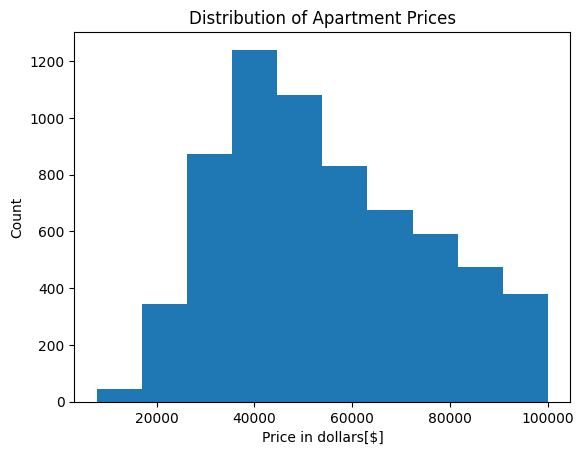

In [4]:
#Histogram of distribution of apartment prices
plt.hist(df["price_aprox_usd"])

# Label axes
plt.xlabel("Price in dollars[$]")
plt.ylabel("Count")
# Add title
plt.title("Distribution of Apartment Prices")

From the histogram above, we can see that the distribution is a skewed.

Text(0.5, 1.0, 'Mexico City: Price vs. Area')

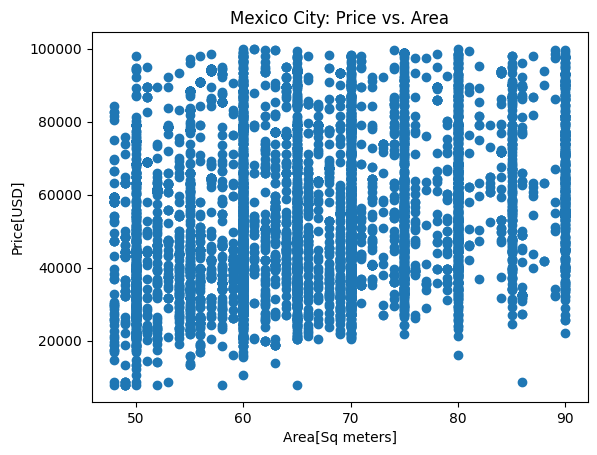

In [5]:
#scatterplot for apartment price 
# Build scatter plot
plt.scatter(x=df["surface_covered_in_m2"], y=df["price_aprox_usd"])


# Label axes
plt.xlabel("Area[Sq meters]")
plt.ylabel("Price[USD]")

# Add title
plt.title("Mexico City: Price vs. Area")



In [6]:
#map box showing location of the apartments i n our datasets and their costs
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat="lat",
    lon="lon",
    width=600,  # Width of map
    height=600,  # Height of map
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

**Model building and predictions**

In [7]:
y=df['price_aprox_usd'] #target dataset
X=df.drop('price_aprox_usd', axis=1) #feature dataset

Split data into training and testing sets (80% training, 20% test)

In [8]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Creating a pipeline for the model 

In [9]:
#building the model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
#fitting the model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

Model evaluation

In [10]:
#Make predictions on the test data
predictions = model.predict(X_test)

# Evaluate the model using regression metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")

Mean Absolute Error (MAE): 14659.390299122084
Mean Squared Error (MSE): 322012613.7227334
Root Mean Squared Error (RMSE): 17944.709909127352
R-squared (R2) Score: 0.24297135925840863


Big MAE and RMSE and a higher R2 means the model is predicting poorly and hence needs more tuning to perform as expected. I will continue turning this model untill it improves. For now, this is all I got. Signed out; October 16th 2AM EAT

In [12]:
#feature importance for the model
coefficients = model.named_steps["ridge"].coef_
features =   model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp

borough_Xochimilco                   48.903090
surface_covered_in_m2               267.566704
lat                                 462.894396
borough_Cuauhtémoc                 -568.363825
borough_Iztacalco                  1295.849678
borough_Miguel Hidalgo             1370.331573
borough_Azcapotzalco               2069.077026
borough_Álvaro Obregón             2442.231761
borough_Coyoacán                   2527.343721
lon                               -2901.305991
borough_Cuajimalpa de Morelos      5184.367546
borough_Venustiano Carranza       -5755.726157
borough_Gustavo A. Madero         -6746.851834
borough_La Magdalena Contreras    -7307.201828
borough_                           7920.470460
borough_Tlalpan                   10825.831940
borough_Iztapalapa               -13114.903687
borough_Benito Juárez             14162.767803
borough_Tláhuac                  -14354.127265
dtype: float64

<AxesSubplot: title={'center': 'Feature Importance for Apartment Price'}, xlabel='Importance [USD]', ylabel='Feature'>

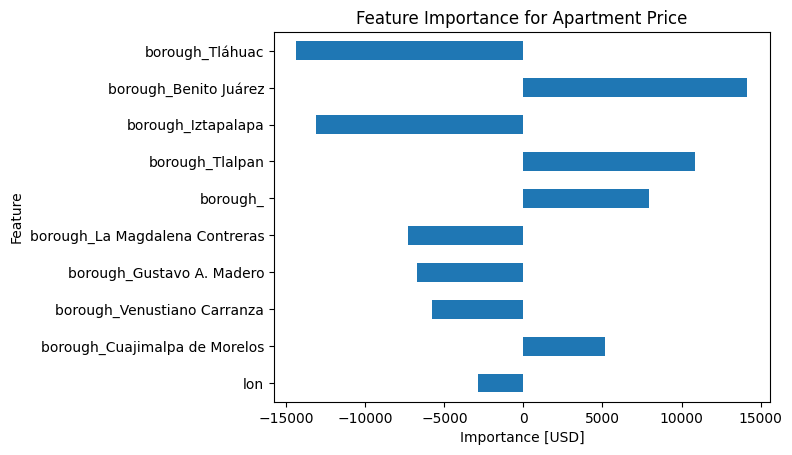

In [14]:
#visualization of the above
# Build bar chart
feat_imp.sort_values(key=abs).tail(10).plot.barh(


# Label axes
xlabel="Importance [USD]",
ylabel="Feature",

# Add title
title="Feature Importance for Apartment Price")